Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Importing the necessary libraries

In [5]:
import random
import hashlib
%matplotlib inline

Method for displaying the images from each class in the test and train dataset chosen randomly

In [6]:
def display_images(data_folders, sample_size=1):
    for data_folder in data_folders:
        print (data_folder)
        image_files = os.listdir(data_folder)
        image_samples = random.sample(image_files, sample_size)
        for image_sample in image_samples:
            image_file = os.path.join(data_folder, image_sample)
            image = Image(image_file)
            display(image)
display_images(train_folders)
display_images(test_folders)

notMNIST_large/A


notMNIST_large/B


notMNIST_large/C


notMNIST_large/D


notMNIST_large/E


notMNIST_large/F


notMNIST_large/G


notMNIST_large/H


notMNIST_large/I


notMNIST_large/J


notMNIST_small/A


notMNIST_small/B


notMNIST_small/C


notMNIST_small/D


notMNIST_small/E


notMNIST_small/F


notMNIST_small/G


notMNIST_small/H


notMNIST_small/I


notMNIST_small/J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000, False)
test_datasets = maybe_pickle(test_folders, 1800, False)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

We will now randomly select a pickle file and take 8 random images from that sample for displaying

In [8]:
def display_random_pickle(data_folders):
    data_folder = random.sample(data_folders, 1)
    pickle_file_name = data_folder[0] + '.pickle'
    print ('Getting data from pickle file', pickle_file_name)
    try:
        with open(pickle_file_name, 'rb') as pickle_file:
            dataset = pickle.load(pickle_file)
    except Exception as e:
        print ('Unable to load data from pickle file ', pickle_file_name, ' Error: ', e)
        return
    plt.suptitle(data_folder[-1])
    for index, image in enumerate(random.sample(dataset, 8)):
        plt.subplot(2, 4, index + 1)
        plt.axis('off')
        plt.imshow(image)

**Display Train Data**

Getting data from pickle file notMNIST_large/I.pickle


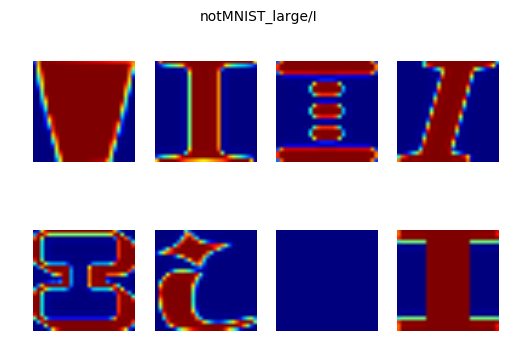

In [9]:
display_random_pickle(train_folders)

**Display Test Data**

Getting data from pickle file notMNIST_small/H.pickle


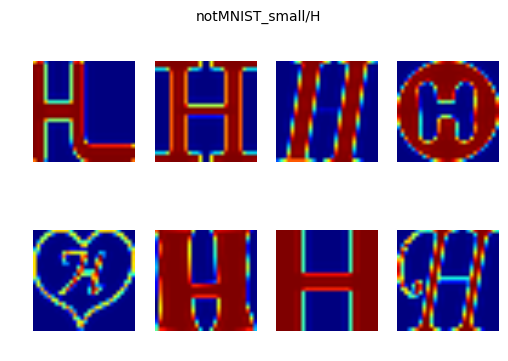

In [10]:
display_random_pickle(test_folders)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

To verify that the data is properly balanced, we can simply check if the number of images in each of the classes are more or less the same.

In [11]:
def display_image_count(data_folders):
    for data_folder in data_folders:
        pickle_file_name = data_folder + '.pickle'
        try:
            with open(pickle_file_name, 'rb') as pickle_file:
                dataset = pickle.load(pickle_file)
        except Exception as e:
            print ('Unable to load data from pickle file ', pickle_file_name, ' Error: ', e)
            return
        print ('Number of images in the folder ', data_folder,' is: ', len(dataset))

Printing the number of images for test and train dataset

In [12]:
display_image_count(train_folders)
display_image_count(test_folders)

Number of images in the folder  notMNIST_large/A  is:  52909
Number of images in the folder  notMNIST_large/B  is:  52911
Number of images in the folder  notMNIST_large/C  is:  52912
Number of images in the folder  notMNIST_large/D  is:  52911
Number of images in the folder  notMNIST_large/E  is:  52912
Number of images in the folder  notMNIST_large/F  is:  52912
Number of images in the folder  notMNIST_large/G  is:  52912
Number of images in the folder  notMNIST_large/H  is:  52912
Number of images in the folder  notMNIST_large/I  is:  52912
Number of images in the folder  notMNIST_large/J  is:  52911
Number of images in the folder  notMNIST_small/A  is:  1872
Number of images in the folder  notMNIST_small/B  is:  1873
Number of images in the folder  notMNIST_small/C  is:  1873
Number of images in the folder  notMNIST_small/D  is:  1873
Number of images in the folder  notMNIST_small/E  is:  1873
Number of images in the folder  notMNIST_small/F  is:  1872
Number of images in the folder

The data is balanced as the number of images in the different classes are almost similar

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [13]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class + tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [14]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [15]:
correct_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def disp_randomized_dataset(dataset, labels):
    items = random.sample(range(len(labels)), 8)
    for index, item in enumerate(items):
        plt.subplot(2, 4, index+1)
        plt.axis('off')
        plt.title(correct_labels[labels[item]])
        plt.imshow(dataset[item])

Testing on the train dataset after randomization

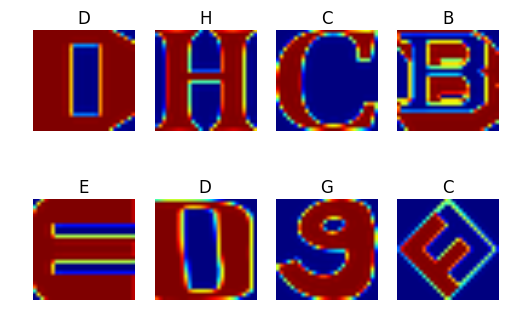

In [16]:
disp_randomized_dataset(train_dataset, train_labels)

Testing on the test dataset after randomization

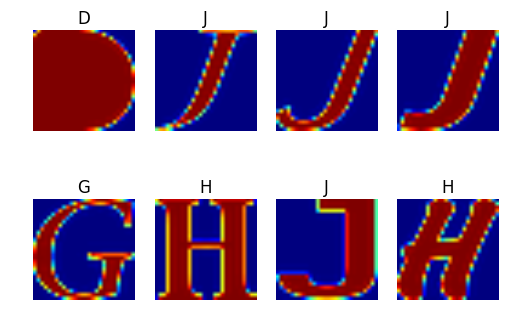

In [17]:
disp_randomized_dataset(test_dataset, test_labels)

Validation dataset after randomization

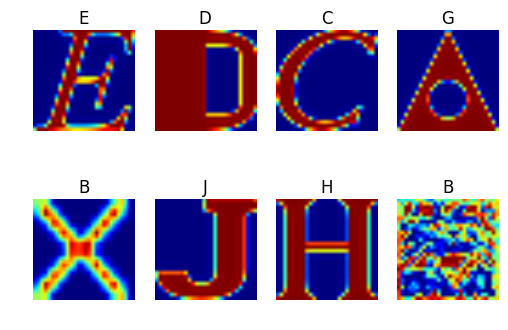

In [18]:
disp_randomized_dataset(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [19]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [20]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

There can be two kind of overlaps:
- Exact overlaps
- Near Overlaps

Exact overlaps are the ones where the exact replica of the image is there in the test and the train dataset, where as in case of near duplicates the images can have just few pixels which are different.

In [21]:
def find_exact_overlap(dataset_1, dataset_2):
    overlap_dict = {}
    for i, image_1 in enumerate(dataset_1):
        for j, image_2 in enumerate(dataset_2):
            if np.array_equal(image_1, image_2):
                if not i in overlap_dict:
                    overlap_dict[i] = list()
                overlap_dict[i].append(j)
    return overlap_dict

Testing the above code on a smaller dataset as this is a brute-force approach and has a time complexity of O(n*m)

In [ ]:
%time exact_overlap_test_train = find_exact_overlap(test_dataset[:100], train_dataset)

In [ ]:
print (exact_overlap_test_train)

So, we found that there are some overlaps in the data, now we will show these images

In [22]:
def display_overlaps(overlap_dict, source_dataset, target_dataset):
    item = random.choice(overlap_dict.keys())
    images = np.concatenate(([source_dataset[item]], target_dataset[overlap_dict[item][:3]]))
    plt.suptitle(item)
    for index, image in enumerate(images):
        plt.subplot(2, 4, index + 1)
        plt.axis('off')
        plt.imshow(image)

In [ ]:
print ('Number of overlaps ', len(exact_overlap_test_train.keys()))
display_overlaps(exact_overlap_test_train, test_dataset[:100], train_dataset)

One way to find out near duplicates is by computing the manhattan distance

In [23]:
MAX_MANHATTAN_NORM = 10

def find_near_overlap(dataset_1, dataset_2):
    overlap_dict = {}
    for i, image_1 in enumerate(dataset_1):
        for j, image_2 in enumerate(dataset_2):
            diff = image_1 - image_2
            m_norm = np.sum(np.abs(diff))
            if m_norm < MAX_MANHATTAN_NORM:
                if not i in overlap_dict.keys():
                    overlap_dict[i] = []
                overlap_dict[i].append(j)
    return overlap_dict

In [ ]:
%time near_overlap_test_train = find_near_overlap(test_dataset[:100], train_dataset)

In [ ]:
print (near_overlap_test_train)

Displaying these near overlaps

In [ ]:
print ('Number of overlaps ', len(near_overlap_test_train.keys()))
display_overlaps(near_overlap_test_train, test_dataset[:100], train_dataset)

This is very slow, so we will try to optimize it using the hash function and few numpy methods

In [26]:
def find_exact_overlap_using_hash(dataset_1, dataset_2):
    hash_dataset_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    hash_dataset_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap_dict = {}
    for i, hash1 in enumerate(hash_dataset_1):
        duplicates = np.where(hash_dataset_2 == hash1)
        if duplicates:
            overlap_dict[i] = duplicates
    return overlap_dict

In [27]:
%time exact_hash_overlap_test_train = find_exact_overlap_using_hash(test_dataset[:100], train_dataset)

CPU times: user 2.5 s, sys: 26.1 ms, total: 2.52 s
Wall time: 2.55 s


In [28]:
print (exact_hash_overlap_test_train)

{0: (array([], dtype=int64),), 1: (array([], dtype=int64),), 2: (array([], dtype=int64),), 3: (array([], dtype=int64),), 4: (array([], dtype=int64),), 5: (array([], dtype=int64),), 6: (array([], dtype=int64),), 7: (array([], dtype=int64),), 8: (array([], dtype=int64),), 9: (array([], dtype=int64),), 10: (array([], dtype=int64),), 11: (array([118818, 183654]),), 12: (array([], dtype=int64),), 13: (array([], dtype=int64),), 14: (array([], dtype=int64),), 15: (array([156759]),), 16: (array([], dtype=int64),), 17: (array([174599]),), 18: (array([], dtype=int64),), 19: (array([], dtype=int64),), 20: (array([], dtype=int64),), 21: (array([], dtype=int64),), 22: (array([], dtype=int64),), 23: (array([], dtype=int64),), 24: (array([], dtype=int64),), 25: (array([], dtype=int64),), 26: (array([38364]),), 27: (array([], dtype=int64),), 28: (array([116004]),), 29: (array([], dtype=int64),), 30: (array([21214, 50715]),), 31: (array([], dtype=int64),), 32: (array([], dtype=int64),), 33: (array([157

Number of overlaps  100


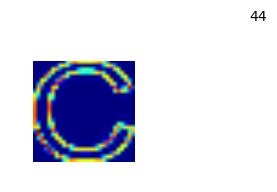

In [29]:
print ('Number of overlaps ', len(exact_hash_overlap_test_train.keys()))
display_overlaps(exact_hash_overlap_test_train, test_dataset[:100], train_dataset)

In [32]:
def sanitize_dataset(dataset_1, dataset_2, label_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap_dict = [] # list of indexes
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap_dict.append(i) 
    return np.delete(dataset_1, overlap_dict, 0), np.delete(label_1, overlap_dict, None)

In [33]:
%time test_dataset_sanitized, test_labels_sanitized = sanitize_dataset(test_dataset[:100], train_dataset, test_labels[:100])
print('Overlapping images removed: ', len(test_dataset[:100]) - len(test_dataset_sanitized))

CPU times: user 2.83 s, sys: 46.8 ms, total: 2.88 s
Wall time: 3.31 s
Overlapping images removed:  10


In [35]:
%time test_dataset_sanitized, test_labels_sanitized = sanitize_dataset(test_dataset, train_dataset, test_labels)
print('Overlapping images removed: ', len(test_dataset) - len(test_dataset_sanitized))

CPU times: user 24.2 s, sys: 271 ms, total: 24.5 s
Wall time: 25 s
Overlapping images removed:  1324


In [36]:
%time valid_dataset_sanitized, velid_labels_sanitized = sanitize_dataset(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanitized))

CPU times: user 28.7 s, sys: 535 ms, total: 29.2 s
Wall time: 30.9 s
Overlapping images removed:  1067


Update the pickle file with the removed images

In [37]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sanitized,
    'valid_labels': velid_labels_sanitized,
    'test_dataset': test_dataset_sanitized,
    'test_labels': test_labels_sanitized,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [38]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 683292701


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [40]:
regr = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

In [41]:
sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 72.1 ms, sys: 6.42 ms, total: 78.5 ms
Wall time: 90.6 ms


0.50900000000000001

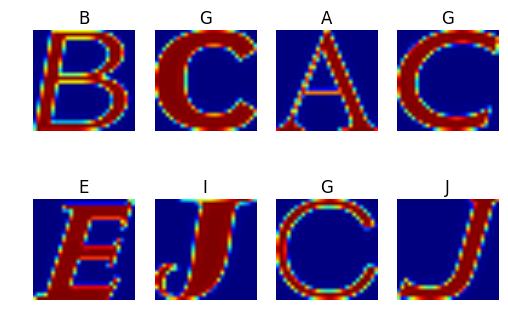

In [42]:
pred_labels = regr.predict(X_test)
disp_randomized_dataset(test_dataset, pred_labels)

In [43]:
sample_size = 100
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 193 ms, sys: 5.36 ms, total: 198 ms
Wall time: 248 ms


0.6966

In [45]:
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 3.91 s, sys: 143 ms, total: 4.06 s
Wall time: 4.52 s


0.83330000000000004

In [46]:
X_valid = valid_dataset[:sample_size].reshape(sample_size, 784)
y_valid = valid_labels[:sample_size]
regr.score(X_valid, y_valid)

0.73599999999999999

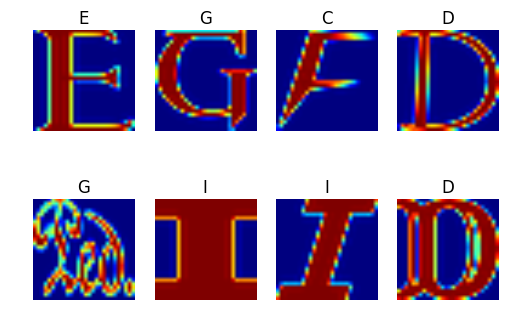

In [47]:
pred_labels = regr.predict(X_valid)
disp_randomized_dataset(valid_dataset, pred_labels)

In [48]:
sample_size = 5000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 35.1 s, sys: 1.29 s, total: 36.4 s
Wall time: 47 s


0.85109999999999997

In [49]:
regr2 = LogisticRegression(solver='sag')
sample_size = len(train_dataset)
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr2.fit(X_train, y_train)
regr2.score(X_test, y_test)

CPU times: user 17min 47s, sys: 25.2 s, total: 18min 12s
Wall time: 19min 47s


0.89319999999999999

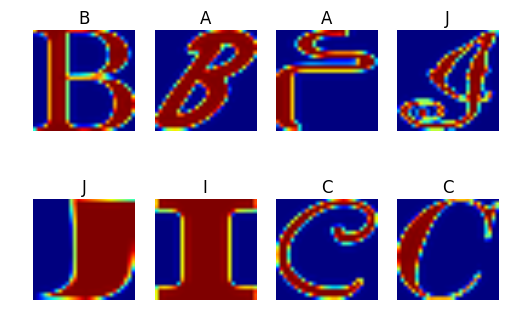

In [51]:
pred_labels = regr.predict(X_test)
disp_randomized_dataset(test_dataset, pred_labels)